In [1]:
import importlib
import Utils.dataset_preparation as pfl
importlib.reload(pfl)
print(dir(pfl))


['DataFrame', 'OneHotEncoder', 'SMOTE', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'model_input_preparation', 'np', 'os', 'pd', 'train_test_split']


# import lib and function

In [96]:
import kagglehub
import pandas as pd
import os
import numpy as np
from pathlib import Path
from pyspark.sql import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance
import shap
from Utils.path_file_loader import target_path
from Utils.dataset_preparation import model_input_preparation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
import optuna
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, accuracy_score, roc_auc_score,  confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm



sns.set(style="white")


# Data Preprocessing

In [3]:
df = pd.read_csv(target_path("DataBase\Cleaned_data.csv"), encoding="utf-8")
df = df.drop(columns=['customerID'])
df = df.rename(columns={'Churn': 'label'})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
categorical_feature_list = ["gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

numerical_feature_list = [
    'SeniorCitizen', 
    'tenure', 
    'MonthlyCharges',
    'TotalCharges', 
]

one_hot_feature = ['tenure',
 'Contract_Two year',
 'TotalCharges',
 'Contract_Month-to-month',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'PaperlessBilling_No',
 'MultipleLines_No',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'DeviceProtection_No internet service',
 'StreamingTV_No internet service',
 'OnlineBackup_No internet service',
 'TechSupport_No internet service',
 'StreamingMovies_No internet service',
 'PhoneService_Yes',
 'Dependents_Yes',
 'StreamingMovies_No',
 'OnlineSecurity_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'TechSupport_Yes',
 'StreamingMovies_Yes',
 'Partner_No',
 'OnlineSecurity_No',
 'gender_Male',
 'StreamingTV_No',
 'PaymentMethod_Mailed check',
 'TechSupport_No',
 'PaymentMethod_Bank transfer (automatic)',
 'StreamingTV_Yes',
 'gender_Female',
 'Partner_Yes',
 'OnlineBackup_Yes', 
 'Dependents_No',
'SeniorCitizen', 
'PhoneService_No', 
'MultipleLines_No phone service',
'Contract_One year']

normal_selected_feature = [
    'Contract', 
    'tenure', 
    'MonthlyCharges', 
    'OnlineSecurity', 
    'TechSupport', 
    'InternetService', 
    'PaymentMethod', 
    'PaperlessBilling', 
    'TotalCharges', 
    'StreamingMovies', 
    'MultipleLines', 
    'OnlineBackup', 
    'SeniorCitizen'
]

# Auto Tuning Parametor

In [5]:
def model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test, tree_base: bool):

    if tree_base:
        for col in x_train.select_dtypes(include="object").columns:
            x_train[col] = x_train[col].astype("category")
            x_test[col] = x_test[col].astype("category")

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True
    )
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


# Model

## Vector Base

### Logistic Regression

In [59]:
def Logistic_model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    C = trial.suggest_categorical("C", [0.1, 1, 10])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs"])


    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if penalty == "l2" and solver not in ["liblinear", "saga", "lbfgs"]:
        raise optuna.exceptions.TrialPruned()

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=100,
    )

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


In [56]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

In [36]:
y_train.value_counts()

label
0    4138
1    1496
Name: count, dtype: int64

In [37]:
y_test.value_counts()

label
0    1036
1     373
Name: count, dtype: int64

In [10]:
X_train

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.396433,-0.278033,-0.110545,-0.325082,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.0
1,-0.396433,1.106671,1.018370,1.419067,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0
2,-0.396433,-1.117247,-1.555277,-0.929060,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.0
3,-0.396433,-0.991365,0.076153,-0.830417,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.0
4,-0.396433,-1.159208,-0.213491,-0.939844,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8271,-0.396433,1.652160,0.360291,1.494552,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.0,0.348152,0.651848,0.000000,1.000000,0.348152,0.0,0.651848,0.0
8272,-0.396433,-0.445876,0.254826,-0.374295,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.186776,0.0,0.813224,0.0
8273,-0.396433,-0.571758,0.759927,-0.359648,1.000000,0.000000,0.235296,0.764704,0.235296,0.764704,...,0.764704,1.0,0.000000,0.000000,0.235296,0.764704,0.764704,0.0,0.235296,0.0
8274,-0.396433,0.183535,0.535477,0.328419,0.999021,0.000979,0.999021,0.000979,1.000000,0.000000,...,1.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.0


In [57]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8218594748048261


In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: Logistic_model_automating_Hyperparamrter(trial, X_train, y_train, X_test, y_test), n_trials=100)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-26 23:59:40,728] A new study created in memory with name: no-name-dc75f8b2-32e3-4bfd-b721-4ce521edd52d
[I 2025-09-26 23:59:40,756] Trial 0 finished with value: 0.8197303051809794 and parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8197303051809794.
c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-09-26 23:59:40,969] Trial 1 finished with value: 0.8190205819730305 and parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.8197303051809794.
[I 2025-09-26 23:59:41,039] Trial 2 finished with value: 0.8225691980127751 and parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.8225691980127751.
[I 2025-09-26 23:59:41,217] Trial 3 finished with value: 0.8204400283889283 and parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}. Best is 

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best accuracy: 0.8232789212207239


In [42]:
model = LogisticRegression(
    random_state=42,
    C = 1,
    penalty='l1',
    solver='saga'
).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8232789212207239


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [43]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



ROC AUC Score: 0.8624310350181664


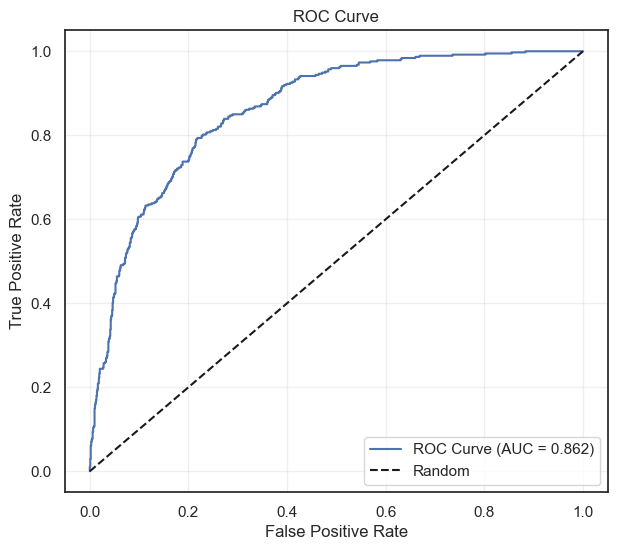

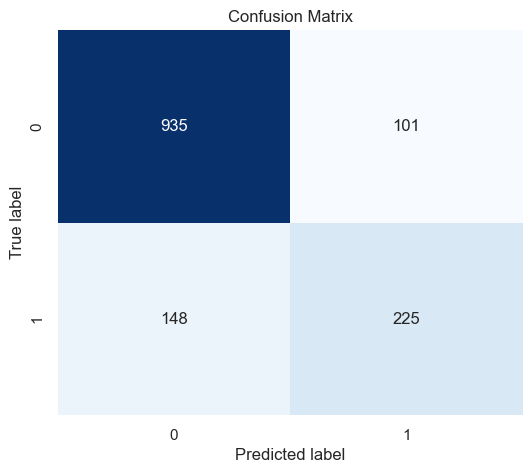

In [44]:
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------
# Confusion Matrix
# ------------------------
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

### Naive Bayes

In [94]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = True
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.39520739 -0.39520739 -0.39520739 ... -0.39520739 -0.39520739
 -0.39520739]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.29037792  1.09027201 -1.12713545 ... -1.12713545  0.67189325
 -1.00162182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

In [95]:
model = GaussianNB().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.7550749154180764, test set 0.7061745919091554


### SVM

In [100]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

In [101]:
model = svm.SVC().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8166489172878949, test set 0.8097941802696949


## Tree Base

### Decision Tree

In [70]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = False,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = True
)

In [71]:
y_train.value_counts()

label
0    4138
1    4138
Name: count, dtype: int64

In [76]:
def decision_tree_model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    max_depth = trial.suggest_int("max_depth", 1 ,40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)

    model = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


In [72]:
model = tree.DecisionTreeClassifier().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.9990333494441759, test set 0.71611071682044


In [77]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: decision_tree_model_automating_Hyperparamrter(trial, X_train, y_train, X_test, y_test), n_trials=200)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-27 00:07:32,136] A new study created in memory with name: no-name-5e06ccb4-5a0d-4edf-adf7-d0fe0ee4cb45
[I 2025-09-27 00:07:32,209] Trial 0 finished with value: 0.7267565649396736 and parameters: {'max_depth': 27, 'min_samples_split': 6}. Best is trial 0 with value: 0.7267565649396736.
[I 2025-09-27 00:07:32,278] Trial 1 finished with value: 0.7317246273953159 and parameters: {'max_depth': 35, 'min_samples_split': 7}. Best is trial 1 with value: 0.7317246273953159.
[I 2025-09-27 00:07:32,333] Trial 2 finished with value: 0.7750177430801988 and parameters: {'max_depth': 9, 'min_samples_split': 12}. Best is trial 2 with value: 0.7750177430801988.
[I 2025-09-27 00:07:32,400] Trial 3 finished with value: 0.7395315826827538 and parameters: {'max_depth': 29, 'min_samples_split': 15}. Best is trial 2 with value: 0.7750177430801988.
[I 2025-09-27 00:07:32,467] Trial 4 finished with value: 0.7317246273953159 and parameters: {'max_depth': 29, 'min_samples_split': 9}. Best is trial 2 wi

Best parameters: {'max_depth': 5, 'min_samples_split': 11}
Best accuracy: 0.7771469127040455


In [78]:
model = tree.DecisionTreeClassifier(
            max_depth=5,
        min_samples_split=11).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8173030449492509, test set 0.7771469127040455


In [79]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



ROC AUC Score: 0.8084481455795128


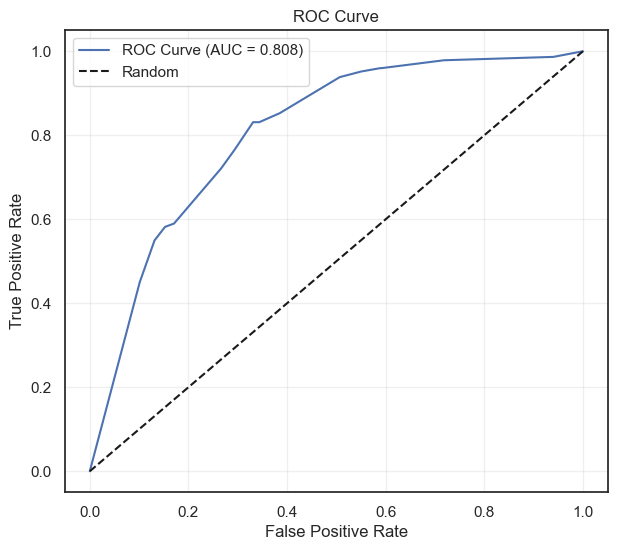

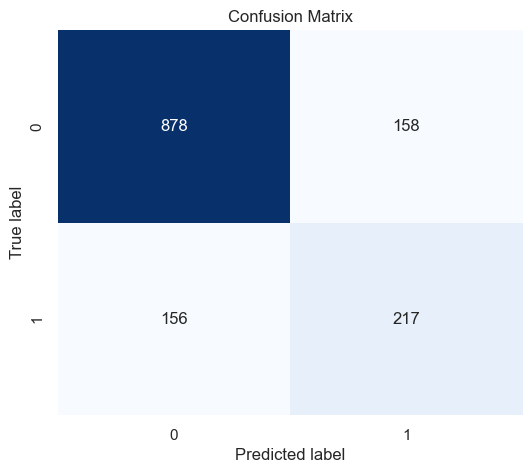

In [80]:
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------
# Confusion Matrix
# ------------------------
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

### Random Forest

In [88]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = False,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

In [83]:
def random_forest_model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    n_estimators = trial.suggest_int("max_depth", 50 ,300)
    max_depth = trial.suggest_int("max_depth", 1, 30)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth
    )

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


In [89]:
model = RandomForestClassifier().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.9985800496982605, test set 0.7913413768630234
